# Word Level Federated Text Generation: Pre-training centrally using Shakespeare's Text and fine-tuning on Stack Overflow in Federated style
- Arjun Singh
- 02-09-20

**About:**

This notebook runs the tensor-flow based training using an LSTM based network on Shakespeare text data and then leverages this pre-trained model to fine-tune Stackoverflow Data in a federated way using the TFF library.

loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip install tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

In [5]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Set Tensorflow to Use GPU

In [8]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)`
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')


### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

### Important Note: The goal is to run the pre-training using some data (centrally) anf then fine-tuning using different/new data in a federated manner. After a few experiments with how to go about this, we decided to only invoke the "construct_word_level_datasets()" function once with the centralized_train flag set to False. 

### This allows us to use the same train and val datasets as before for federated fine-tuning. However, now we get a much larger Test Dataset, which is actually being used to "centrally pre-train".

In [10]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 50000

NUM_ROUNDS = 500
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

## The next cell includes hyperparams for this test run

In [11]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 50
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 1000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 500

NUM_ROUNDS = 5
NUM_TRAIN_CLIENTS = 2
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [12]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [13]:
type(train_data)

tensorflow_federated.python.simulation.client_data.ConcreteClientData

In [14]:
type(val_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [15]:
type(test_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

### Retrieve the Dataset Vocab

#### Here the vocab remains the same for both the pre-training and fine-tuning since we're leveraging the same dataset

In [29]:
vocab = dataset.get_vocab(VOCAB_SIZE)

In [30]:
len(vocab)

10000

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [31]:
pad, oov, bos, eos = dataset.get_special_tokens(VOCAB_SIZE)

In [32]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

## Now we try to use a different text corpus for pre-training. The Shakespeare Text Dataset is used.

#### The vocab for pre-training is now different from that of fine-tuning, so that must be handled first.

#### Also, the major benefits of doing this in the same notebook as the previous pre-training/fine-tuning approach is to save time of accessing the TFF SO dataset and also to make a comparison of all the training processes together.

In [33]:
## Using a different data set (such as Shakespeare, and later Wikipedia) to do the central Pre-Training using TensorFlow
with open('../../../raw_shakespeare_data.txt') as f:
    # This reads all the data from the file, but does not do any processing on it.
    data = f.read()

In [35]:
# preprocessing to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
data = " ".join(data.split())

In [36]:
data[:100]

'The Project Gutenberg EBook of The Complete Works of William Shakespeare, by William Shakespeare Thi'

In [37]:
len(data.split())

904065

In [38]:
VOCAB_SIZE

10000

In [39]:
word_counts_sp = collections.OrderedDict()
for word in data.split():
    word_counts_sp[word] = word_counts_sp.get(word, 0) + 1

In [40]:
vocab_sp = list(word_counts_sp.keys())[:VOCAB_SIZE]

In [41]:
len(vocab_sp)

10000

### Set Vocabulary for Shakespeare Dataset
Add one to account for the pad token which has idx 0.

In [42]:
word2idx_sp = {word:i+1 for i, word in enumerate(vocab_sp)}
idx2word_sp = {i+1:word for i, word in enumerate(vocab_sp)}

In [43]:
len(word2idx_sp)

10000

### Add Special Characters

In [44]:
word2idx_sp = {**word2idx_sp, **special2idx}
idx2word_sp = {**idx2word_sp, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [45]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [46]:
word2idx_sp['The']

1

In [47]:
encoded = []
for word in data.split():
    if not word2idx_sp.get(word,0):
        encoded.append(oov)
    else:
        encoded.append(word2idx_sp[word])

In [48]:
encoded[:10]

[1, 2, 3, 4, 5, 1, 6, 7, 5, 8]

In [49]:
len(encoded)

904065

In [50]:
X = list()
Y = list()
for i in range(len(encoded)-1):
    X.append(encoded[i])
    Y.append(encoded[i + 1])

In [51]:
X[:5]

[1, 2, 3, 4, 5]

In [52]:
Y[:5]

[2, 3, 4, 5, 1]

In [53]:
len(X), len(Y)

(904064, 904064)

In [54]:
type(X), type(Y)

(list, list)

In [55]:
X = np.expand_dims(X, 1)
Y = np.expand_dims(Y, 1)

In [56]:
type(X), type(Y)

(numpy.ndarray, numpy.ndarray)

In [57]:
X.shape, Y.shape

((904064, 1), (904064, 1))

### Next is the attempted pre-training using the Shakespeare corpus

### Load or Build the Model and Try Generating Some Text

In [58]:
embedding_matrix='uniform'

In [62]:
keras_model_sp = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

In [65]:
evaluation_metrics_sp = validation.get_metrics(VOCAB_SIZE)
model.compile_model(keras_model_sp, evaluation_metrics_sp)

In [66]:
keras_model_sp

In [67]:
keras_model_sp.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense_4 (Dense)              (None, None, 100)         25700     
_________________________________________________________________
dense_5 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


In [75]:
PRE_TRAIN_EPOCHS=1

In [76]:
history = keras_model_sp.fit(X, Y, epochs=PRE_TRAIN_EPOCHS)

Train on 904064 samples
904064/904064 [==============================] - 1398s 2ms/sample - loss: 4.8701 - num_tokens: 904064.0000 - num_tokens_no_oov: 715492.0000 - num_batches: 28252.0000 - num_examples: 904064.0000 - accuracy: 0.2367 - accuracy_no_oov: 0.0621 - accuracy_no_oov_no_eos: 0.0621- loss: 4.8702 - num_tokens: 901024.0000 - num_tokens_no_oov: 713


In [81]:
keras_model_sp.evaluate(val_data)

10/10 [==============================] - 6s 583ms/step - loss: 8.4967 - num_tokens: 13487.0000 - num_tokens_no_oov: 13070.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0153 - accuracy_no_oov: 0.0042 - accuracy_no_oov_no_eos: 0.0044


[8.496688222885131,
 13487,
 13070,
 10,
 1000,
 0.015348113,
 0.0042081103,
 0.0044491184]

In [82]:
keras_model_sp.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense_4 (Dense)              (None, None, 100)         25700     
_________________________________________________________________
dense_5 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [83]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

### Initialize Train and Validation Model Trackers to be Used Below

In [84]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

### Set the Default Executor

In [85]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [86]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Next we initialize the model for the Federated Learning (fine-tuning) process with the weights learned from the previously pre-trained model (saved as keras_model)

### It can be seen next the only the trainable_weights need to be transferred to the model for fine-tuning, as the non_trainable_weights are empty.

### It can also be seen that trainable variables are identical to the trainable weights for the pre-trained model

In [87]:
from src import transfer_learning

### Following is the step where the transfer learning actually takes place

In [89]:
server_state = transfer_learning.learn_from_pretrained_model(iterative_process, keras_model_sp)

### Now it can be seen that the relevant weights are identical

In [90]:
keras_model_sp.trainable_weights[0].numpy() == server_state.model[0][0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [91]:
keras_model_sp.trainable_weights[1].numpy() == server_state.model[0][1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [92]:
NUM_ROUNDS = 5

In [93]:
from tqdm import tqdm

### Next we perform the actual FL based fine-tuning, following which we compare the results (loss and accuracy) from this pretraining/fine-tuning based approach to the earlier approach of only performing FL based training without any form of pre-training

In [94]:
SAVE_DIR = 'temp_results/'

In [108]:
train_metrics_tracker_sp = validation.model_history_tracker(evaluation_metric_names)
val_metrics_tracker_sp = validation.model_history_tracker(evaluation_metric_names)

In [107]:
val_metrics_tracker_sp.get_metrics_by_name('loss')

[]

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating before training round #0 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 17s 2s/step - loss: 7.8956 - num_tokens: 13578.0000 - num_tokens_no_oov: 13064.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0115 - accuracy_no_oov: 0.0020 - accuracy_no_oov_no_eos: 0.0021
Sampling 2 new clients.


 20%|██        | 1/5 [00:40<02:40, 40.02s/it]

Round: 0
   Loss: 10.94998455
   num_batches: 8
   num_examples: 100
   num_tokens: 1283
   num_tokens_no_oov: 1255
   accuracy: 0.00935
   accuracy_no_oov: 0.00398
Evaluating before training round #1 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 10s 1s/step - loss: 7.7573 - num_tokens: 13154.0000 - num_tokens_no_oov: 12758.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0092 - accuracy_no_oov: 0.0023 - accuracy_no_oov_no_eos: 0.0024
Sampling 2 new clients.


 40%|████      | 2/5 [01:18<01:58, 39.47s/it]

Round: 1
   Loss: 10.62520218
   num_batches: 8
   num_examples: 100
   num_tokens: 1414
   num_tokens_no_oov: 1363
   accuracy: 0.02405
   accuracy_no_oov: 0.00367
Evaluating before training round #2 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 10s 974ms/step - loss: 7.5295 - num_tokens: 12933.0000 - num_tokens_no_oov: 12489.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0107 - accuracy_no_oov: 0.0026 - accuracy_no_oov_no_eos: 0.0028
Sampling 2 new clients.


 60%|██████    | 3/5 [01:49<01:14, 37.15s/it]

Round: 2
   Loss: 10.63468361
   num_batches: 8
   num_examples: 100
   num_tokens: 1214
   num_tokens_no_oov: 1179
   accuracy: 0.00988
   accuracy_no_oov: 0.00254
Evaluating before training round #3 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 13s 1s/step - loss: 7.7560 - num_tokens: 13385.0000 - num_tokens_no_oov: 13021.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0076 - accuracy_no_oov: 0.0015 - accuracy_no_oov_no_eos: 0.0015
Sampling 2 new clients.


 80%|████████  | 4/5 [02:26<00:37, 37.12s/it]

Round: 3
   Loss: 10.75565910
   num_batches: 8
   num_examples: 100
   num_tokens: 1421
   num_tokens_no_oov: 1389
   accuracy: 0.00633
   accuracy_no_oov: 0.00288
Evaluating before training round #4 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 12s 1s/step - loss: 7.9543 - num_tokens: 14087.0000 - num_tokens_no_oov: 13678.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0084 - accuracy_no_oov: 0.0020 - accuracy_no_oov_no_eos: 0.0021
Sampling 2 new clients.


100%|██████████| 5/5 [03:02<00:00, 36.51s/it]

Round: 4
   Loss: 10.29265213
   num_batches: 8
   num_examples: 100
   num_tokens: 1043
   num_tokens_no_oov: 1020
   accuracy: 0.01055
   accuracy_no_oov: 0.00392


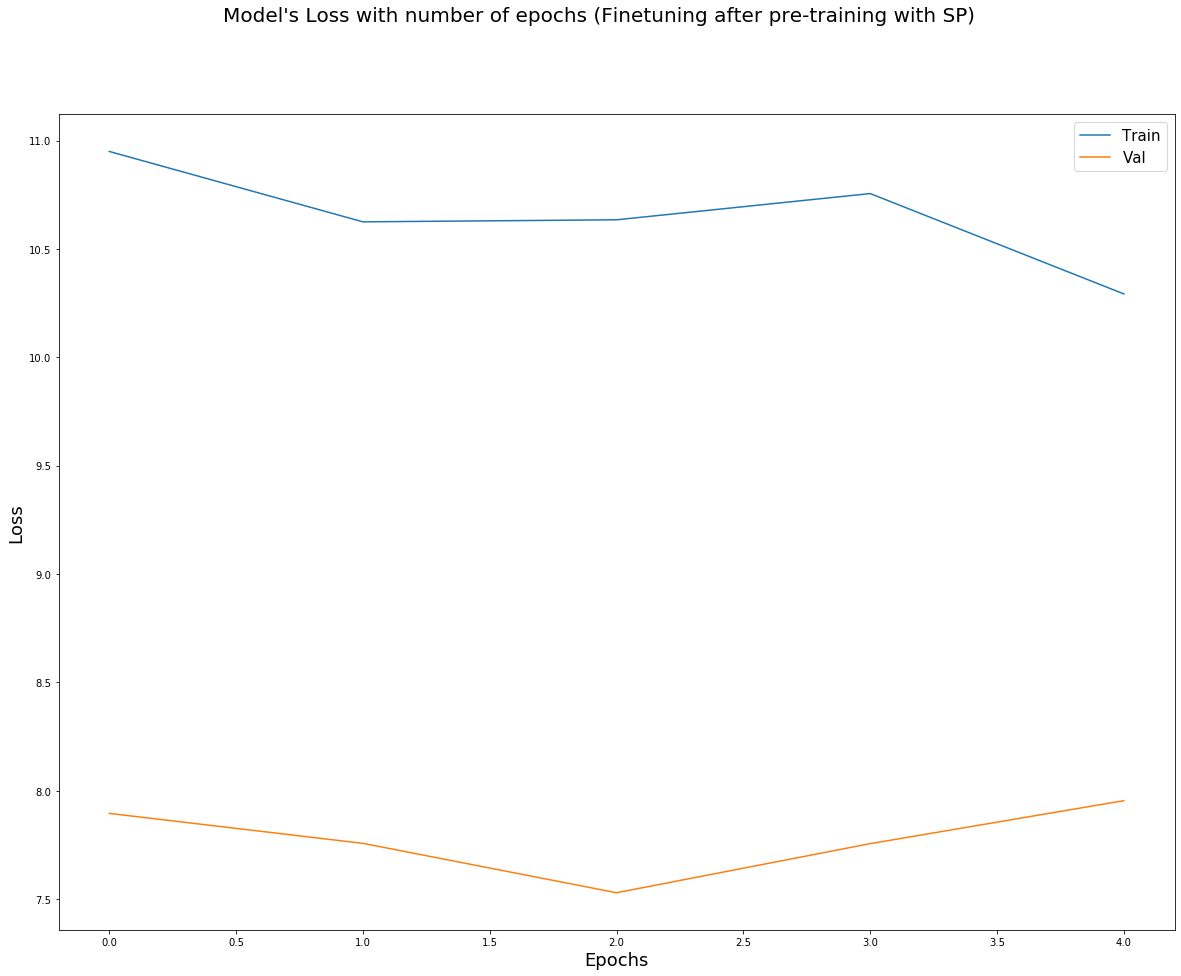

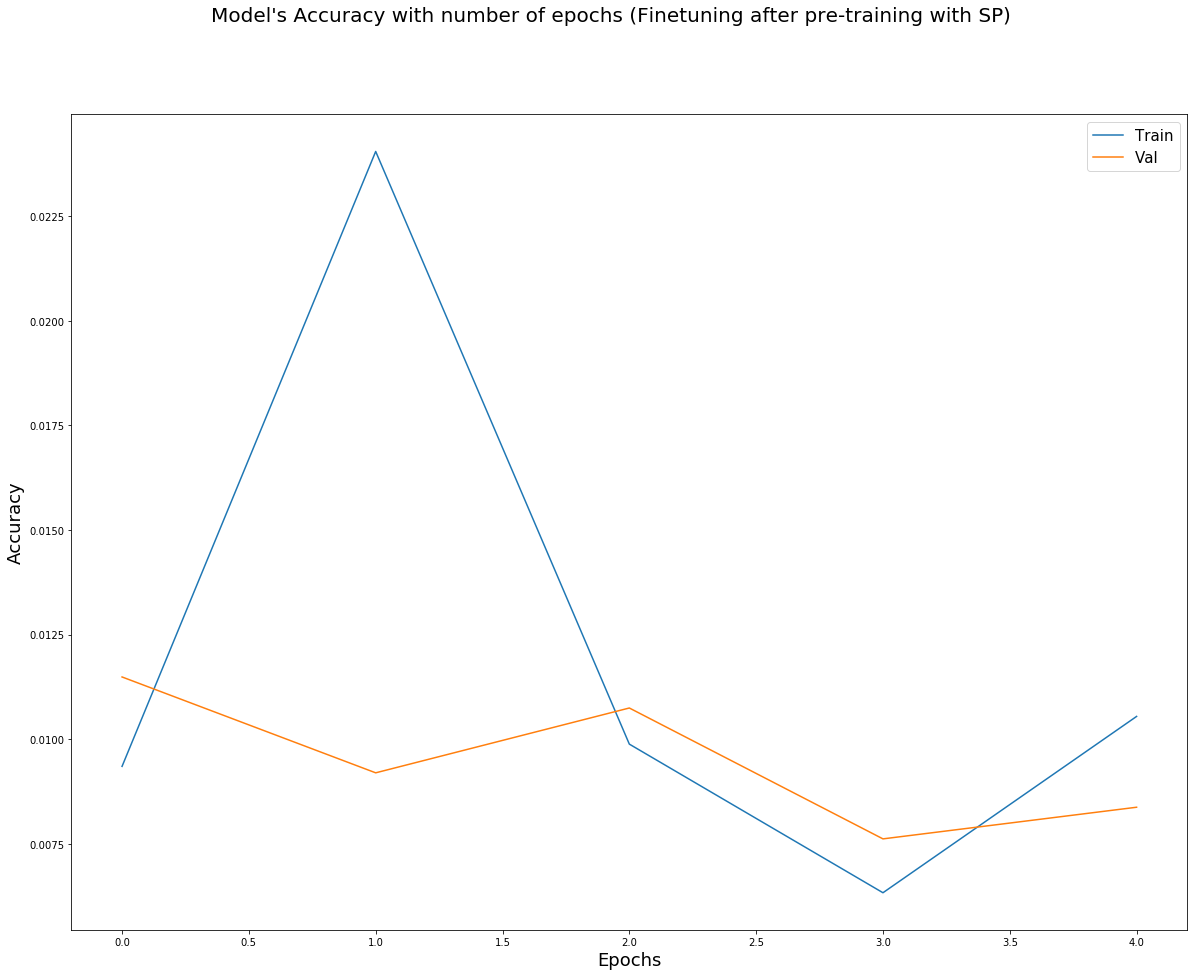

In [109]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):
        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        validation.keras_evaluate(state=server_state,
                          val_dataset=val_data,
                          extended_vocab_size=EXTENDED_VOCAB_SIZE,
                          vocab_size=VOCAB_SIZE,
                          embedding_dim=EMBEDDING_DIM,
                          embedding_matrix=embedding_matrix,
                          rnn_units=RNN_UNITS,
                          metrics_tracker=val_metrics_tracker_sp)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        train_clients = federated.get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics_sp = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics_sp.loss))
        print('   num_batches: {}'.format(server_metrics_sp.num_batches))
        print('   num_examples: {}'.format(server_metrics_sp.num_examples))
        print('   num_tokens: {}'.format(server_metrics_sp.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics_sp.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics_sp.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics_sp.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker_sp.add_metrics_by_name('loss', server_metrics_sp.loss)
        train_metrics_tracker_sp.add_metrics_by_name('accuracy', server_metrics_sp.accuracy)
        
        np.save(SAVE_DIR + 'train_accuracy_finetuning_sp.npy', train_metrics_tracker_sp.get_metrics_by_name('accuracy'))
        np.save(SAVE_DIR + 'val_accuracy_finetuning_sp.npy', val_metrics_tracker_sp.get_metrics_by_name('accuracy'))
        
        np.save(SAVE_DIR + 'train_loss_finetuning_sp.npy', train_metrics_tracker_sp.get_metrics_by_name('loss'))
        np.save(SAVE_DIR + 'val_loss_finetuning_sp.npy', val_metrics_tracker_sp.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs (Finetuning after pre-training with SP)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig(SAVE_DIR + 'Loss_with_Epochs_finetuning_sp.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs (Finetuning after pre-training with SP)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig(SAVE_DIR + 'Accuracy_with_Epochs_finetuning_sp.jpg')
    plt.show()

### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretraining

In [94]:
import numpy as np
train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

### Plot Model's Loss for both models, with and without the Shakespeare based pre-training

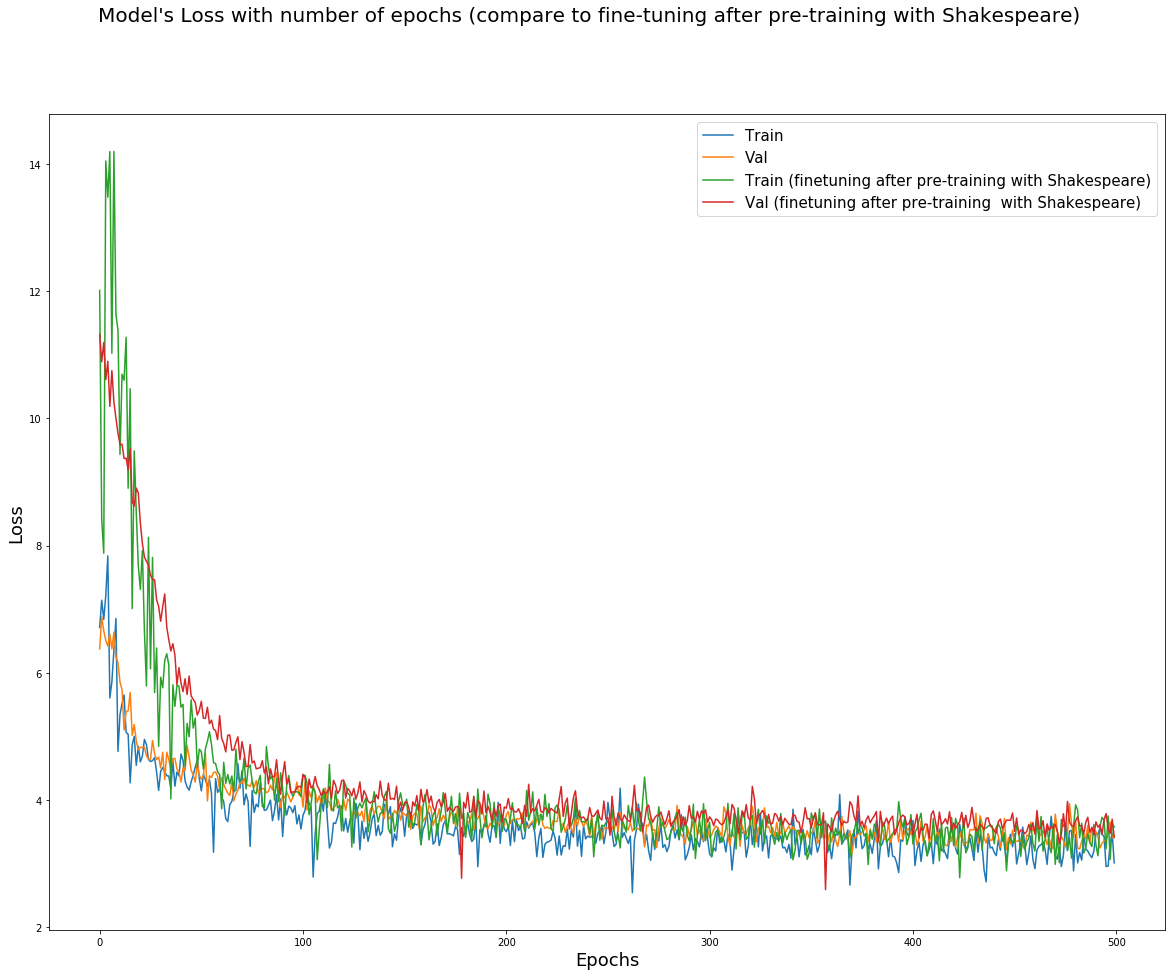

In [95]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val (finetuning after pre-training  with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs (compare to fine-tuning after pre-training with Shakespeare)', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_compare_finetuning_sp.jpg')
plt.show()

### Plot Model's Accuracy for both models, with and without the Shakespeare based pre-training

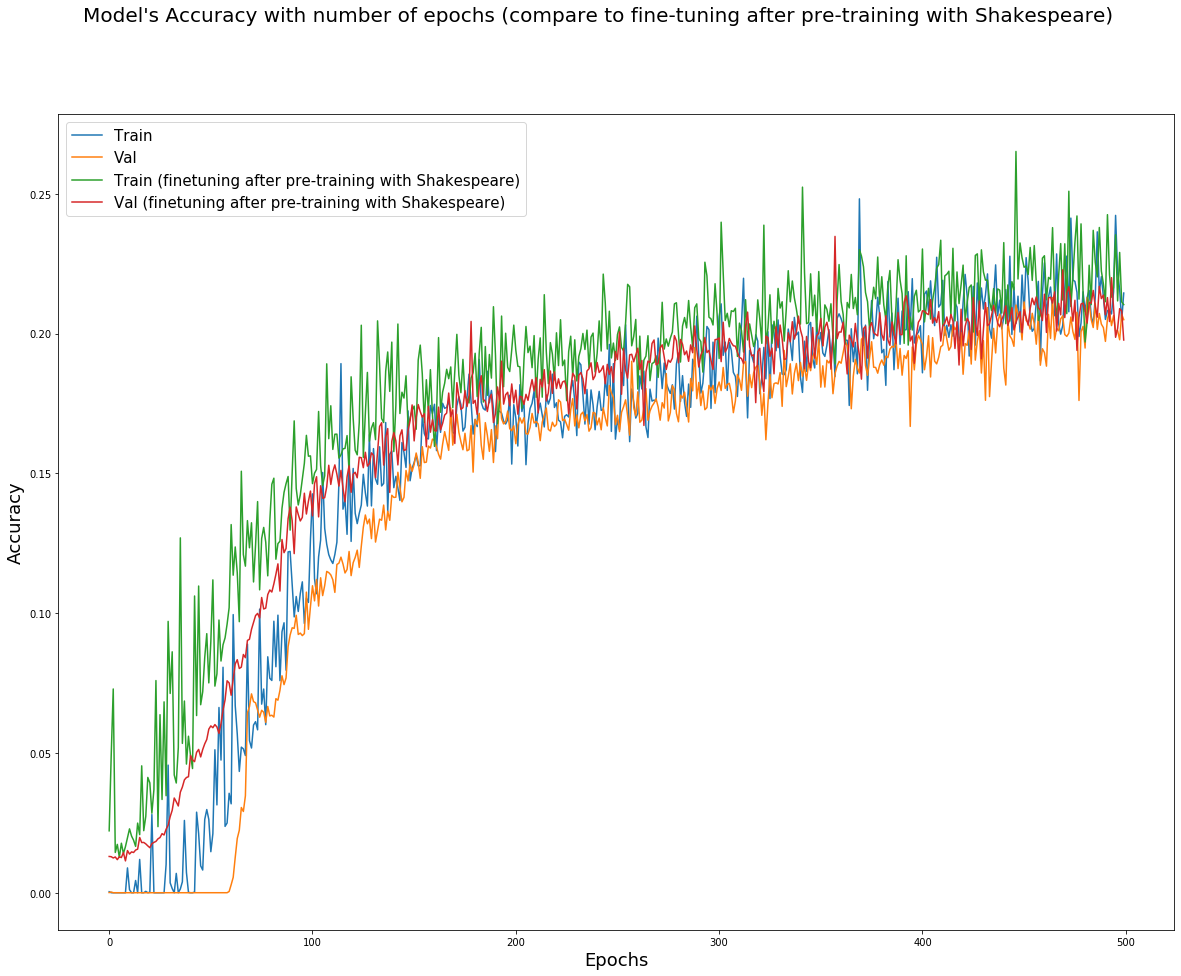

In [96]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs (compare to fine-tuning after pre-training with Shakespeare)', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_compare_finetuning_sp.jpg')
plt.show()

In [98]:
train_loss_finetuning_so = np.load('train_loss_finetuning.npy')
train_accuracy_finetuning_so = np.load('train_accuracy_finetuning.npy')
val_loss_finetuning_so = np.load('val_loss_finetuning.npy')
val_accuracy_finetuning_so = np.load('val_accuracy_finetuning.npy')

## Plots comparing no pre-training, pre-training with SO and pre-training with Shakespeare

### First the Loss Plot

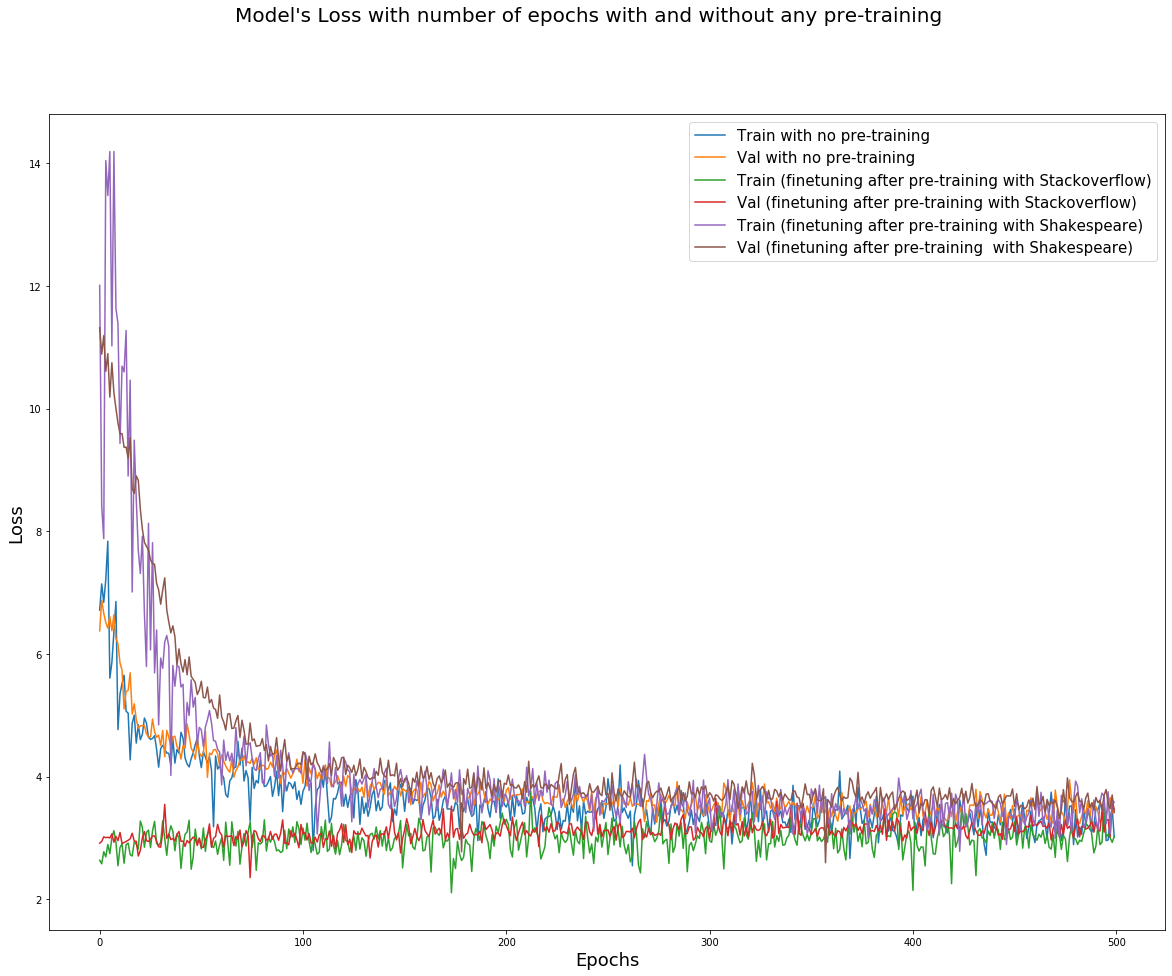

In [100]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_loss_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_loss_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val (finetuning after pre-training  with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs with and without any pre-training', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_with_without_pretrain.jpg')
plt.show()

### Next the Accuracy Plot

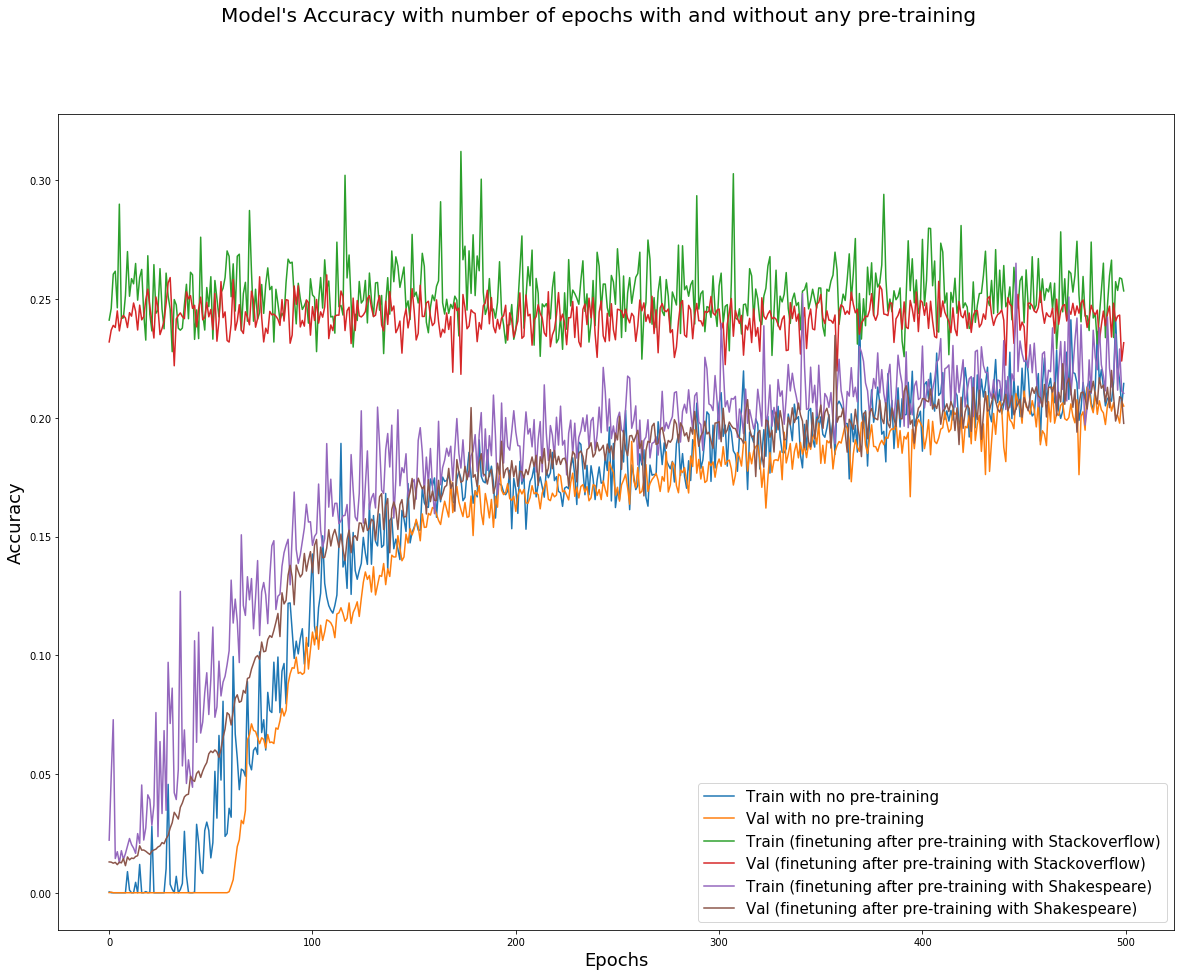

In [101]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_accuracy_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_accuracy_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs with and without any pre-training', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_with_without_pretrain.jpg')
plt.show()

### Loading the results from the training done using the pre-trained GloVe Word Embeddings layer

In [102]:
train_loss_with_pt_embed = np.load('train_loss_with_pt_embed.npy')
train_accuracy_with_pt_embed = np.load('train_accuracy_with_pt_embed.npy')
val_loss_with_pt_embed = np.load('val_loss_with_pt_embed.npy')
val_accuracy_with_pt_embed = np.load('val_accuracy_with_pt_embed.npy')

## Plots comparing no pre-training, pre-training with SO and pre-training with Shakespeare, as well as the pre-trained GloVe Word Embedding Layer's results

### First the Loss Plot

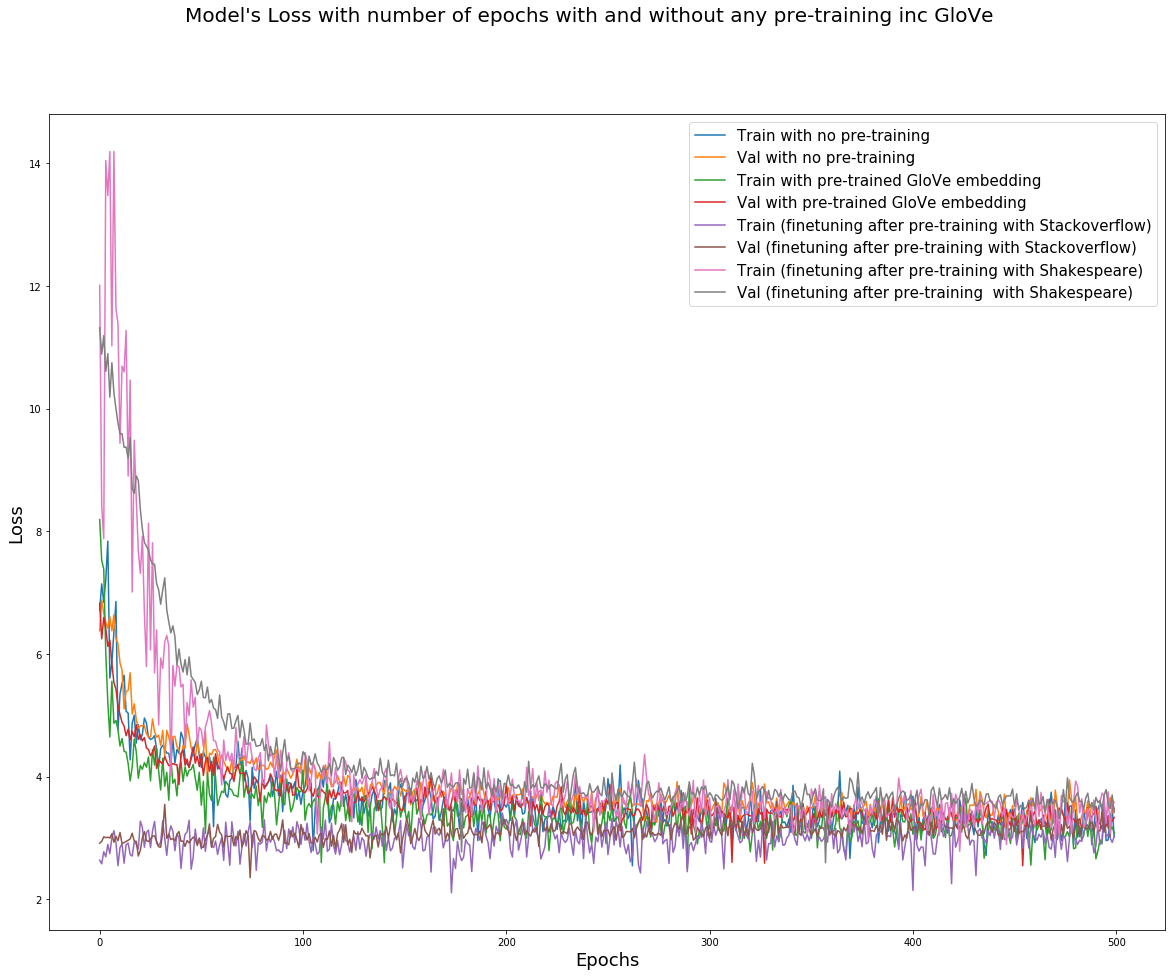

In [103]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_loss_with_pt_embed, label='Train with pre-trained GloVe embedding')
ax.plot(x_axis, val_loss_with_pt_embed, label='Val with pre-trained GloVe embedding')
ax.plot(x_axis, train_loss_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_loss_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('loss'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('loss'), label='Val (finetuning after pre-training  with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs with and without any pre-training inc GloVe', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_with_without_pretrain_inc_glove.jpg')
plt.show()

### Next the Accuracy Plot

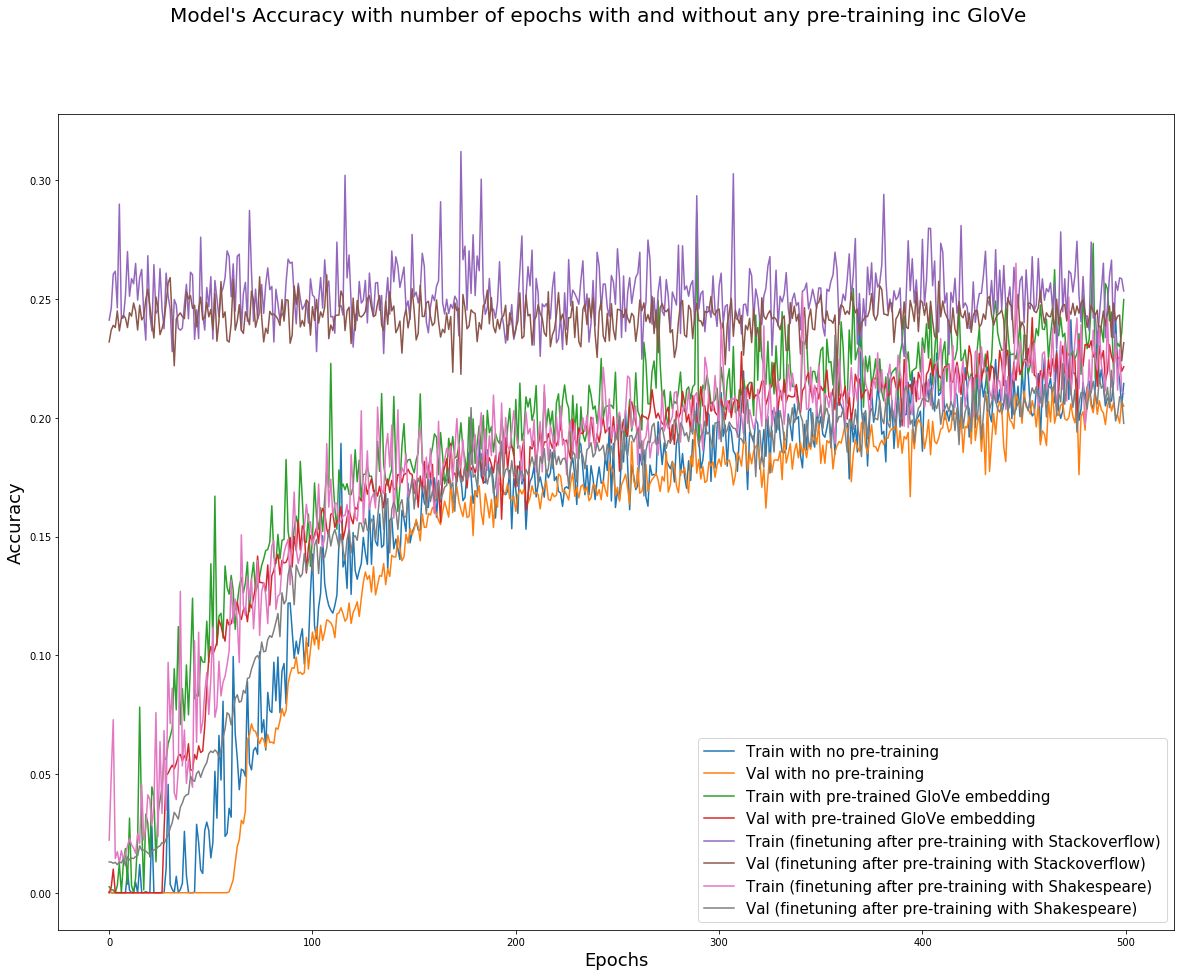

In [104]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train with no pre-training')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val with no pre-training')
ax.plot(x_axis, train_accuracy_with_pt_embed, label='Train with pre-trained GloVe embedding')
ax.plot(x_axis, val_accuracy_with_pt_embed, label='Val with pre-trained GloVe embedding')
ax.plot(x_axis, train_accuracy_finetuning_so, label='Train (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, val_accuracy_finetuning_so, label='Val (finetuning after pre-training with Stackoverflow)')
ax.plot(x_axis, train_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training with Shakespeare)')
ax.plot(x_axis, val_metrics_tracker_sp.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training with Shakespeare)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs with and without any pre-training inc GloVe', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_with_without_pretrain_inc_glove.jpg')
plt.show()